In [4]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [5]:
# Which versions are installed?
import sys
print("Python version")
print (sys.version)
print("\nPandas info")
print (pd.__version__)

Python version
3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]

Pandas info
0.25.3


# Data-Prep Pipeline from Previous Lessons
## Custom transformers

In [6]:
# A class that changes category names according to specified rules
class Country2ContinentConverter(BaseEstimator, TransformerMixin):
    ''' This transformer revises categories according to a dictionary with rules '''
    def __init__(self, country_col='native-country', continent_col='continent', conversion_rules={}):
        self.country_col = country_col
        self.continent_col = continent_col
        self.conversion_rules = conversion_rules
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        X_transformed[self.continent_col] = ''
        for country in self.conversion_rules:
            X_transformed.loc[X[self.country_col]==country, self.continent_col] = self.conversion_rules[country]
        return X_transformed

In [7]:
# A class that changes category names according to specified rules
class CategoryReviser(BaseEstimator, TransformerMixin):
    ''' This transformer revises categories according to a dictionary with rules '''
    def __init__(self, cat_change_rules={}):
        self.cat_change_rules = cat_change_rules

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        for feature in self.cat_change_rules:
            for cat in self.cat_change_rules[feature]:
                X_transformed.loc[X[feature]==cat, feature] = self.cat_change_rules[feature][cat]
        return X_transformed

In [8]:
# Here, we regularize the target encodeing by taking the weighted average of the positive rate for the specific category
# and the positive rate for the entire dataset. The argument 'reg_weight' controls the weighting.
class TargetEncoder(BaseEstimator, TransformerMixin):
    ''' This transformer replaces a category with the regularized positive rate for that category '''
    def __init__(self, features, reg_weight=20):
        self.features = features
        self.reg_weight = reg_weight
        self.mapping = {}

    def fit(self, X, y=None):
        self.X_positive_rate = y.mean()
        X_y = X.copy()
        X_y['target'] = y
        for feat in self.features:
            cat_positive_rates = {}
            for feat in self.features:
                self.mapping[feat] = {}
                positive_rates = X_y.groupby(feat)['target'].mean()
                value_counts = X_y[feat].value_counts()
                for cat in X_y[feat].unique():
                    n = value_counts.loc[cat]
                    rate = positive_rates.loc[cat]
                    regularized_rate = (rate * n + self.X_positive_rate * self.reg_weight) / (n + self.reg_weight)
                    self.mapping[feat][cat] = regularized_rate
        return self
    
    def transform(self, X, y=None):
        X_transformed = X.copy()
        for feat in self.mapping:
            for cat in X[feat].unique():
                try:
                    # If the category was mapped during fitting, change it. 
                    X_transformed.loc[X[feat]==cat, feat] = self.mapping[feat][cat]
                except: 
                    # If the category is unknown, replace it with the mean positive rate
                    X_transformed.loc[X[feat]==cat, feat] = self.X_positive_rate
                    
        return X_transformed

In [9]:
class CharacterStripper(BaseEstimator, TransformerMixin):
    ''' Strip a charapter from the end of a string'''
    def __init__(self, character_to_strip='.'):
        self.character_to_strip = character_to_strip

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = X
        X_transformed = X_transformed.str.strip(self.character_to_strip)
        return X_transformed

## Data-prep Functions

In [10]:
def get_data(columns_to_drop=None):
    ''' Downloan the data, and create train and test sets. '''
    df_1 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", 
                   names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
                   'marital-status', 'occupation', 'relationship', 'race', 'sex', 
                   'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 
                   '>=50K'], skipinitialspace=True)
    df_2 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test", 
                   names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
                   'marital-status', 'occupation', 'relationship', 'race', 'sex', 
                   'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 
                   '>=50K'], skipinitialspace=True, skiprows=1)
    df_combined = df_1.append(df_2, ignore_index=True, sort=True)
    if columns_to_drop:
        df_combined = df_combined.drop(columns=columns_to_drop)
    X = df_combined.drop(columns=['>=50K'])
    y = df_combined['>=50K']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    return X_train, X_test, y_train, y_test

In [11]:
def preprocess_y(y):
    ''' Remove dots from the end and encode the target feature. '''
    character_stripper = CharacterStripper(character_to_strip='.')
    y_stripped = character_stripper.fit_transform(y)
    label_encoder = LabelEncoder()
    y_train_prepared = label_encoder.fit_transform(y_stripped)
    return y_train_prepared

In [12]:
def build_X_pipeline_full(predictor=None):
    ''' Build pipeline with all the features. '''
    num_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',]
    cat_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'continent']

    cat_change_rules = {'marital-status':{'Married-AF-spouse':'Married', 'Married-civ-spouse':'Married'}, 
                        'workclass':{'Without-pay':'?', 'Never-worked':'?'},
                        'occupation':{'Armed-Forces':'Prof-specialty'}}
    country_2_contonent_rules = {'United-States':'N-America',
                         'Germany':'Europe',
                         'Mexico':'LatAm',
                         'Scotland':'Europe',
                         'Peru':'LatAm',
                         'Honduras':'LatAm',
                         'Ecuador':'LatAm',
                         'Poland':'Europe',
                         'China':'Asia',
                         'Nicaragua':'LatAm',
                         'India':'Asia',
                         'Philippines':'Asia',
                         'Iran':'Asia',
                         'Japan':'Asia',
                         'Vietnam':'Asia',
                         'Dominican-Republic':'LatAm',
                         'Ireland':'Europe',
                         'Laos':'Asia',
                         'Jamaica':'LatAm',
                         'England':'Europe',
                         'Hong':'Asia',
                         'Puerto-Rico':'LatAm',
                         'Cuba':'LatAm',
                         'Haiti':'LatAm',
                         'Guatemala':'LatAm',
                         'El-Salvador':'LatAm',
                         'Columbia':'LatAm',
                         'Italy':'Europe',
                         'Taiwan':'Asia',
                         'Canada':'N-America',
                         'Portugal':'Europe',
                         'Thailand':'Asia',
                         'Cambodia':'Asia',
                         'France':'Europe',
                         'Greece':'Europe',
                         'Trinadad&Tobago':'LatAm',
                         'Yugoslavia':'Europe',
                         'Hungary':'Europe',
                         'Holand-Netherlands':'Europe',
                        }

    # Create and parametatrize data transformers
    scaler = StandardScaler()
    one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
    category_reviser = CategoryReviser(cat_change_rules=cat_change_rules)
    country_2_continent = Country2ContinentConverter(country_col='native-country', 
                                                     continent_col='continent', 
                                                     conversion_rules=country_2_contonent_rules)
    target_encoder = TargetEncoder(['native-country'])

    column_transformer = ColumnTransformer([('Scaler', scaler, num_features), 
                                            ('One Hot Encoder', one_hot_encoder, cat_features)])

    # Define the data transformation pipeline
    X_pipeline = Pipeline([('CategoryReviser', category_reviser), 
                           ('Country2Continent', country_2_continent), 
                           ('TargetEncoder', target_encoder), 
                           ('ColumnTransformer', column_transformer),
                           ('predictor', predictor)])
    
    if predictor == None:
        X_pipeline.steps.pop()
    
    return X_pipeline

In [13]:
def build_X_pipeline_partial(predictor=None):
    ''' Build pipeline without ethically sensitive features. '''
    num_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
    cat_features = ['workclass', 'occupation']

    cat_change_rules = {'workclass':{'Without-pay':'?', 'Never-worked':'?'},
                        'occupation':{'Armed-Forces':'Prof-specialty'}}

    # Create and parametatrize data transformers
    scaler = StandardScaler()
    one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
    category_reviser = CategoryReviser(cat_change_rules=cat_change_rules)

    column_transformer = ColumnTransformer([('Scaler', scaler, num_features), 
                                            ('One Hot Encoder', one_hot_encoder, cat_features)])

    # Define the data transformation pipeline
    X_pipeline = Pipeline([('CategoryReviser', category_reviser), 
                           ('ColumnTransformer', column_transformer),
                           ('predictor', predictor)])
    
    if predictor == None:
        X_pipeline.steps.pop()
    
    return X_pipeline

## Putting it all together

In [14]:
X_train, X_test, y_train, y_test = get_data(columns_to_drop=['marital-status', 'relationship', 'race', 
                                                             'sex', 'native-country'])
y_train_prepared = preprocess_y(y_train)
y_test_prepared = preprocess_y(y_test)
X_pipeline = build_X_pipeline_partial()
X_train_prepared = X_pipeline.fit_transform(X_train, y_train_prepared)
X_test_prepared = X_pipeline.transform(X_test)

X_train_prepared.shape, y_train_prepared.shape, X_test_prepared.shape, y_test_prepared.shape

((36631, 27), (36631,), (12211, 27), (12211,))

# Model Training & Selection
Finally, let's train some machine learning models and see what we get!

In order to run this, install XGBoost. From your Anaconda prompt, type `pip3 install xgboost`.

In [17]:
# Let's import everything we will use
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

## Choosing a performance metric
As we learned in Lesson 8, it is a good practice to select a single performance metric that would guide the tuning and selection of models. We are creating a custom metric that is aligned with the business value our model will create:
* True positive: \\$60 profit
* False positive: \\$20 loss
* True negative: \\$20 profit
* False negative: \\$60 loss

See Lesson 8 for more details.

[Learn more about metrics and scoring in sklearn](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [18]:
def mean_value_score(y_true, y_pred, tp_profit=60, tn_profit=20):
    ''' Custom performance metric that calculate the mean monetary profit and loss implications (per row) of our  
        predictions, relative to the alternative of targeting all potential customers. 
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_profit = tp_profit * (tp - fn) + tn_profit * (tn - fp)
    mean_profit = total_profit / len(y_true)
    return mean_profit    

**Confusion Matrix:**

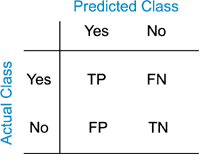


Image by Oritnk, from https://en.wikipedia.org/wiki/File:Binary_confusion_matrix.png. 

In [19]:
# What is a confusion matrix?
a = [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
b = [1, 1, 0, 0, 1, 0, 0, 0, 1, 0]

confusion_matrix(a, b)

array([[4, 1],
       [2, 3]], dtype=int64)

In [82]:
# The ravel methods flattens a matrix into a one-dimensional array
confusion_matrix(a, b).ravel()

array([3, 1, 2, 4], dtype=int64)

In [85]:
mean_value_score(a, b)

12.0

In [61]:
# Here is the maximum value we can get if our model predict everything perfectly
mean_value_score(y_test_prepared, y_test_prepared)

29.352223405126527

## The basics of working with predictors
Suprisingly, perhaps, training a model and using it for predictions is one of the easiest parts of the process. 

In [87]:
# Training a simple logistic regression
log_reg = LogisticRegression(max_iter=1000) # We start with the default parameters, but we may want to increase the number of iterations
pipeline_lr = build_X_pipeline_partial(log_reg) # Here, we build a pipeline that includes the logistic regression
fitted_pipeline = pipeline_lr.fit(X_train, y_train_prepared) # In this line, we're training the model
y_pred = fitted_pipeline.predict(X_test) # In this line, we have the trained model make predictions for the test rows.
y_pred[:20] # Show the beginning of the predicitons

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0])

In [88]:
# How did we do?
print('%.2f' % mean_value_score(y_test_prepared, y_pred))

11.75


## Validation framework
Another thing we need to do early on is selecting a validation framework. Typically we use data in three ways in the training process:
* **Training set** - used for traiing the model.
* **Validation/development set** - data that is held out of the training and is used to assess the performance of models in order to inform their tuning and select the final model. We will use here a simple, randomized cross validation with five folds.
* **Test set** - data that is held out of both training and validation and is used to assess the performance of the selected model on unseen data.

[Learn more about evaluating models' preformance with sklearn](https://scikit-learn.org/stable/modules/cross_validation.html).

In [21]:
# Here is the basic workflow of tuning the hyperparameters of a model
custom_scorer = make_scorer(mean_value_score)

params = {
        'predictor__C': np.logspace(-6, 6, 13),
        }

grid_lr = GridSearchCV(pipeline_lr, params, n_jobs=-1, cv=5, return_train_score=True, scoring=custom_scorer )
grid_lr.fit(X_train, y_train_prepared)

print('Best Params', grid_lr.best_params_)
print('Best score %.2f' % grid_lr.best_score_)

Best Params {'predictor__C': 10.0}
Best score 11.47


In [23]:
grid_lr.cv_results_

{'mean_fit_time': array([0.24275079, 0.20704765, 0.18211293, 0.19428067, 0.34786968,
        0.53177752, 0.9520524 , 1.01508474, 1.14413977, 0.94587007,
        0.94008484, 1.00471258, 0.95086236]),
 'std_fit_time': array([0.03245621, 0.02752035, 0.01202799, 0.01172249, 0.01856665,
        0.03549879, 0.15817173, 0.18088711, 0.17565463, 0.26608515,
        0.16023794, 0.23292831, 0.24039187]),
 'mean_score_time': array([0.05086317, 0.04826999, 0.04348316, 0.0452786 , 0.05305815,
        0.04926748, 0.07739363, 0.07480006, 0.05944104, 0.07180786,
        0.07001252, 0.11269751, 0.04448762]),
 'std_score_time': array([0.00721989, 0.01314959, 0.00223925, 0.00857073, 0.00547656,
        0.00596986, 0.04079314, 0.02768956, 0.01638389, 0.01428652,
        0.01340225, 0.02581586, 0.01945168]),
 'param_predictor__C': masked_array(data=[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                    100.0, 1000.0, 10000.0, 100000.0, 1000000.0],
              mask=[False, False, False, Fa

In [71]:
np.set_printoptions(precision=2)
print('Train %', grid_lr.cv_results_['mean_train_score'])
print('Test', grid_lr.cv_results_['mean_test_score'])

Train % [ 0.71  0.71  1.87  8.5  10.94 11.4  11.45 11.46 11.46 11.47 11.47 11.47
 11.46]
Test [ 0.71  0.71  1.88  8.49 10.96 11.4  11.45 11.47 11.47 11.47 11.47 11.47
 11.47]


In [72]:
# This is how we get the test score. However, we should not take it into account at this point. 
y_pred = grid_lr.predict(X_test) # In this line, we have the trained model make predictions for the test rows.
print('%.2f' % mean_value_score(y_test_prepared, y_pred))

11.75


## Testing different models

In [24]:
# Here is a more sophistic version of logistic regression with:
# 1. It can do it's own cross validation.
# 2. It can use an Elastic Net penalty, which blends L1 and L2 regularization.
log_reg = LogisticRegressionCV(cv=5, solver='saga', penalty='elasticnet', l1_ratios=[0, 0.1, 0.3, 0.5, 0.7, 0.9, 1], n_jobs=-1,
                               scoring=custom_scorer, random_state=0, max_iter=1000).fit(X_train_prepared, y_train_prepared)

In [25]:
print('Best score: %.2f\nBest parameters: l1_ratio %.2f, C %.2f' % (log_reg.scores_[1].max(), log_reg.l1_ratio_, log_reg.C_))

Best score: 11.78
Best parameters: l1_ratio 0.00, C 2.78


In [26]:
# Random forest
rf = RandomForestClassifier(n_estimators=200)

rf_pipeline = build_X_pipeline_partial(rf)

params = {
            'predictor__max_depth': [None, 1, 2, 4, 8, 16],
            'predictor__min_samples_leaf': [1, 3, 10, 30]
         }

grid_rf = GridSearchCV(rf_pipeline, params, n_jobs=-1, cv=5, return_train_score=True, scoring=custom_scorer )
grid_rf.fit(X_train, y_train_prepared)

print('Best Params', grid_rf.best_params_)
print('Best score %.2f' % grid_rf.best_score_)

Best Params {'predictor__max_depth': None, 'predictor__min_samples_leaf': 1}
Best score 13.22


In [27]:
# We can present a predictor with all of its hyperparameters
rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [28]:
# K nearest neighbors
knn = KNeighborsClassifier()

knn_pipeline = build_X_pipeline_partial(knn)

params = {'predictor__weights': ['uniform', 'distance'],
          'predictor__n_neighbors': [1, 3, 10, 30, 100]
         }

grid_knn = GridSearchCV(knn_pipeline, params, n_jobs=-1, cv=5, return_train_score=True, scoring=custom_scorer )
grid_knn.fit(X_train, y_train_prepared)

print('Best Params', grid_knn.best_params_)
print('Best score %.2f' % grid_knn.best_score_)

Best Params {'predictor__n_neighbors': 10, 'predictor__weights': 'distance'}
Best score 11.75


In [40]:
# params = {
#         'predictor__n_estimators': [10, 50, 90, 130, 170, 210, 250],
#         'predictor__learning_rate': [.1],
#         'predictor__max_depth': [None, 1, 2, 3, 5, 7, 9, 11, 13],
#         'predictor__subsample': [.1, .3, .5, .7, .9, 1],
#         'predictor__colsample_bytree': [.1, .3, .5, .7, .9, 1]
#         }

params = {
        'predictor__n_estimators': [239],
        'predictor__learning_rate': [.1],
        'predictor__max_depth': [10],
        'predictor__subsample': [.7],
        'predictor__colsample_bytree': [.3]
        }

xgb = XGBClassifier(n_jobs=-1, random_state=0)

xgb_pipeline = build_X_pipeline_partial(xgb)

grid_xgb = GridSearchCV(xgb_pipeline, params, n_jobs=-1, cv=5, return_train_score=True, 
                    scoring=custom_scorer)
grid_xgb.fit(X_train, y_train_prepared)

print('Best Params', grid_xgb.best_params_)
print('Best score %.3f' % grid_xgb.best_score_)
# print('Train', grid_xgb.cv_results_['mean_train_score'])
# print('Test', grid_xgb.cv_results_['mean_test_score'])
#14.541

Best Params {'predictor__colsample_bytree': 0.3, 'predictor__learning_rate': 0.1, 'predictor__max_depth': 10, 'predictor__n_estimators': 239, 'predictor__subsample': 0.7}
Best score 14.542


In [46]:
# How is our selected model doing on the test set?
y_pred = grid_xgb.predict(X_test)
mean_value_score(y_test_prepared, y_pred)

14.843993120956515

## Let's see how we're doing with the common Accuracy metric
Let's assess ourselves against some solutions out there - we're getting 87.64% accuracy, comparing with [88.16% which was reported in 2018] (https://ieeexplore.ieee.org/abstract/document/8748528) as the best score for ths dataset. Not bad for a quick try! Can you try to improve it?

In [20]:
xgb = XGBClassifier(n_jobs=-1, random_state=0)

X_train_full, X_test_full, _, _ = get_data(columns_to_drop=None)
full_dataset_pipeline = build_X_pipeline_full(xgb)

params = {
        'TargetEncoder__reg_weight': [20],
        'predictor__n_estimators': [156],
        'predictor__learning_rate': [.1],
        'predictor__max_depth': [None],
        'predictor__subsample': [1],
        'predictor__colsample_bytree': [1]
        }

grid_full_ds = GridSearchCV(full_dataset_pipeline, params, n_jobs=-1, cv=5, return_train_score=True)
grid_full_ds.fit(X_train_full, y_train_prepared)

print('Best Params', grid_full_ds.best_params_)
print('Best score %.3f' % grid_full_ds.best_score_)
# print('Train', grid_full_ds.cv_results_['mean_train_score'])
# print('Test', grid_full_ds.cv_results_['mean_test_score'])

Best Params {'TargetEncoder__reg_weight': 20, 'predictor__colsample_bytree': 1, 'predictor__learning_rate': 0.1, 'predictor__max_depth': None, 'predictor__n_estimators': 156, 'predictor__subsample': 1}
Best score 0.874


In [42]:
grid_full_ds.score(X_test_full, y_test_prepared)

0.8764228973876014

In [50]:
# Our trained model with the full dataset is having a better performance of about $3.5 per row, even though it is optimized
# for a different performance metric.
y_pred = grid_full_ds.predict(X_test_full)
mean_value_score(y_test_prepared, y_pred)

18.139382523953813

## Lab - tuning a gradient boosted tree classifier
Tuning a gradient boosted tree, like XGBoost, often works well using the following steps:

1. GBC typically performs better the lower its learning rate is, but requires more estimators (and therefore more training time) for lower learning rates. We will start by setting the learning rate of 0.1, and later try to lower it. 
2. Find the optimal number of trees for this learning rate - this is usually the hyperparameter that has the most influence on the results.
3. Tune tree specific parameters.
4. Lower the learning rate and increase the number of trees.

For demonstration, let's take a version of the dataset with 300 rows and tune it live.

In [28]:
X_pipeline_full = build_X_pipeline_full()
X_train_prepared_full = X_pipeline.fit_transform(X_train, y_train_prepared)
X_test_prepared_full = X_pipeline.transform(X_test)
y_train_prepared = preprocess_y(y_train)
y_test_prepared = preprocess_y(y_test)
X_train_300 = X_test_prepared_full[:300]
y_train_300 = y_train_prepared[:300]

X_train_300.shape, y_train_300.shape

((300, 27), (300,))

In [22]:
from sklearn.model_selection import StratifiedKFold

# Startified K-fold ensures there are enough positive instances in each validation fold.
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for train_index, test_index in strat_kfold.split(X_train_300, y_train_300):
    print("TRAIN:", len(train_index), "VALIDATION:", len(test_index), "Positive rate:", 
          y_train_300[test_index].sum() / len(test_index))

TRAIN: 240 VALIDATION: 60 Positive rate: 0.25
TRAIN: 240 VALIDATION: 60 Positive rate: 0.25
TRAIN: 240 VALIDATION: 60 Positive rate: 0.26666666666666666
TRAIN: 240 VALIDATION: 60 Positive rate: 0.26666666666666666
TRAIN: 240 VALIDATION: 60 Positive rate: 0.26666666666666666


In [66]:
# Let's go together iteratively through the tuning process

xgb_300 = XGBClassifier(n_jobs=-1, random_state=0)

# params = {
#         'n_estimators': [10, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210],
#         'learning_rate': [.1],
#         'max_depth': [None, 1, 2, 3, 5, 7, 9, 11, 13],
#         'subsample': [.1, .3, .5, .7, .9, 1],
#         'colsample_bytree': [.1, .3, .5, .7, .9, 1]
#         }

params = {
        'n_estimators': [157],
        'learning_rate': [.1],
        'max_depth': [None, 1, 2, 3, 5, 7, 9, 11, 13],
        'subsample': [.1, .3, .5, .7, .9, 1],
        'colsample_bytree': [.1, .3, .5, .7, .9, 1]
        }

grid_full_ds = GridSearchCV(xgb_300, params, n_jobs=-1, cv=strat_kfold.split(X_train_300, y_train_300), 
                            return_train_score=True)
grid_full_ds.fit(X_train_300, y_train_300)

print('Best Params', grid_full_ds.best_params_)
print('Best score %.4f' % grid_full_ds.best_score_)
# print('Train', grid_full_ds.cv_results_['mean_train_score'])
# print('Test', grid_full_ds.cv_results_['mean_test_score'])

Best Params {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 157, 'subsample': 0.7}
Best score 0.7467


In [65]:
print('Train', grid_full_ds.cv_results_['mean_train_score'])
print('Test', grid_full_ds.cv_results_['mean_test_score'])


Train [0.99833333 0.99833333 0.99833333 0.99833333 0.99833333 0.99833333
 0.99833333 0.99833333]
Test [0.72       0.72       0.72       0.72       0.71666667 0.72
 0.72       0.72      ]


# Homework
Play with different models and see if you can train a model with improved perofrmance.